### Abrir el fichero y obtener propiedades básicas

Los datos estan estructurados en ficheros con formato HDF5, desde Python una manera muy comoda de trabajar con ellos es con la librería pytables. Para abrir el fichero simplemente hay que importar tables y pasarle el nombre del fichero:

In [1]:
import tables as tb

In [2]:
RWF_file = 'dst_waves.gdcsnext.000_4534.root.h5'
h5rwf = tb.open_file(RWF_file,'r')

Usando el handler del fichero se puede ver la estructura del mismo. Los ficheros hdf5 tienen una estructura de carpetas, en nuestro caso veis que hay una carpeta /RD con varios datasets:

- /RD/pmtblr: waveforms con la deconvolución online de la FPGA.
- /RD/pmtrwf: raw waveforms sin deconvolución (hay que pasarles la offline en este caso).
- /RD/sipmrwf: waveforms de los SiPMs.

La estructura de las waveforms es igual en los tres casos. Son vectores de tres dimensiones donde la primera dimensión es el evento, la segunda dimensión es el evento y la tercera son los bines temporales de la waveform.

In [3]:
h5rwf

File(filename=dst_waves.gdcsnext.000_4534.root.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/RD (Group) ''
/RD/pmtblr (EArray(270, 12, 32000), zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32000)
/RD/pmtrwf (EArray(270, 12, 32000), zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32000)
/RD/sipmrwf (EArray(270, 1792, 800), zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 50, 800)
/Run (Group) ''
/Run/events (Table(270,)) ''
  description := {
  "evt_number": Int32Col(shape=(), dflt=0, pos=0),
  "timestamp": UInt64Col(shape=(), dflt=0, pos=1)}
  byteorder := 'little'
  chunkshape := (32768,)
/Run/runInfo (Table(1,)) ''
  de

Para poder leer esos vectores y obtener información basica sobre ellos hay algunas funciones en IC:

In [4]:
import invisible_cities.reco.tbl_functions as tbl

In [5]:
pmtrwf, pmtblr, sipmrwf = tbl.get_vectors(h5rwf)
NEVT, pmtrwf, sipmrwf, _ = tbl.get_rwf_vectors(h5rwf)
sp = tbl.get_sensor_params_from_vectors(pmtrwf, sipmrwf)
print(sp)

####################
SensorParams
####################
npmt: 12
pmtwl: 32000
nsipm: 1792
sipmwl: 800



Con lo anterior tenemos una variable con cada uno de los arrays de waveforms y también información extra en `sp`, por ejemplo: número de PMTs, tamaño de la waveform, etc. 

In [6]:
print('Number of PMT:', sp.NPMT)
print('PMT wave length:', sp.pmtwl)
print('Number of SiPM:', sp.NSIPM)
print('SiPM wave length:', sp.sipmwl)

Number of PMT: 12
PMT wave length: 32000
Number of SiPM: 1792
SiPM wave length: 800


Para leer waveforms concretas simplemente hay que usar la estructura del array. Por ejemplo, para obtener un array con los 12 pmts del primer evento:

In [7]:
event = 0
pmtrwf[event]

array([[2261, 2260, 2262, ..., 2261, 2261, 2261],
       [2276, 2275, 2276, ..., 2277, 2276, 2275],
       [2223, 2222, 2222, ..., 2223, 2223, 2223],
       ..., 
       [2248, 2251, 2248, ..., 2249, 2250, 2250],
       [2264, 2265, 2264, ..., 2265, 2264, 2265],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=int16)

### Información de la base de datos

Para obtener información sobre los sensores (constantes de calibración, coeficientes del algoritmo BLR, posiciones, etc.) se puede consultar una base de datos, hay que pasarle el run number de los ficheros que se vayan a procesar. En el ejemplo se puede ver el contenido de la tabla (pandas dataframe) que devuelve la base de datos y algunos ejemplos de como extraer columnas concretas de la tabla.

In [8]:
from invisible_cities.database import load_db
import numpy as np

In [9]:
run_number = 4534
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()
channel_id = DataPMT.ChannelID.values
coeff_blr = abs(DataPMT.coeff_blr.values)
coeff_c = abs(DataPMT.coeff_c .values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
adc_to_pes_sipm = abs(DataSiPM.adc_to_pes.values)

In [10]:
DataPMT

,SensorID,ChannelID,PmtID,Active,X,Y,coeff_blr,coeff_c,adc_to_pes,noise_rms,Sigma
0,0,18,PMT1,1,-23.9414,65.7785,0.000788,0.000002,25.023,0.75,10.593
1,1,22,PMT3,1,-44.9951,-53.6231,0.000789,0.000002,26.109,0.78,11.680
2,2,19,PMT2,1,68.9365,-12.1554,0.000775,0.000002,27.741,0.75,10.525
3,3,23,PMT4,1,0.0000,185.0000,0.000778,0.000002,28.359,0.73,10.899
4,4,9,PMTC,1,-118.9160,141.7180,0.000789,0.000002,33.180,0.80,11.838
5,5,8,PMTB,1,-182.1890,32.1249,0.000781,0.000002,24.295,0.78,8.696
6,6,5,PMTA,1,-160.2150,-92.5000,0.000794,0.000002,27.627,0.76,10.326
7,7,4,PMT9,1,-63.2737,-173.8430,0.000773,0.000002,37.206,0.77,14.037
8,8,1,PMT8,1,63.2737,-173.8430,0.000788,0.000002,26.187,0.81,9.270
9,10,31,PMT6,1,182.1890,32.1249,0.000782,0.000002,22.250,0.79,7.941


Para saber a que canal de la electrónica corresponde cada sensor en el array de waveforms hay que utilizar la tabla de arriba, se puede extraer la lista:

In [11]:
channels = DataPMT.ChannelID.values
print(channels)

[18 22 19 23  9  8  5  4  1 31 30  0]


Por ejemplo, la siguiente funcion (demasiado simple, depende de la variable definida arriba), recibe un numero de evento, un canal de eléctronica y devuelve el array con la waveform correspondiente:

In [12]:
chan_to_pos = {}
for i, ch in enumerate(channels):
    chan_to_pos[ch] = i
    
def get_waveform(evt, channel):
    return pmtrwf[evt][chan_to_pos[channel]]

In [13]:
get_waveform(0, 18) # evento 0, canal 18

array([2261, 2260, 2262, ..., 2261, 2261, 2261], dtype=int16)

### Plot waveforms

Hay algunas funciones para hacer plots de las waveforms de un evento concreto, por ejemplo:

In [14]:
import matplotlib.pyplot as plt
import invisible_cities.icaro.mpl_functions as mpl
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

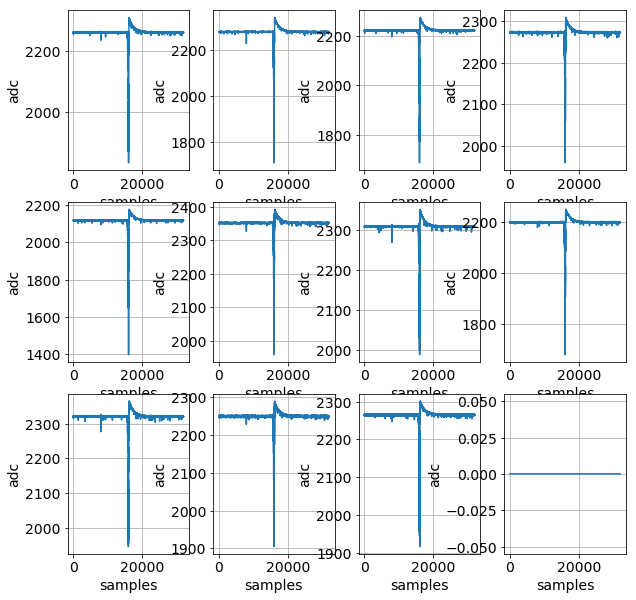

In [15]:
event = 0
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))

Waveforms deconvolucionadas por la FPGA:

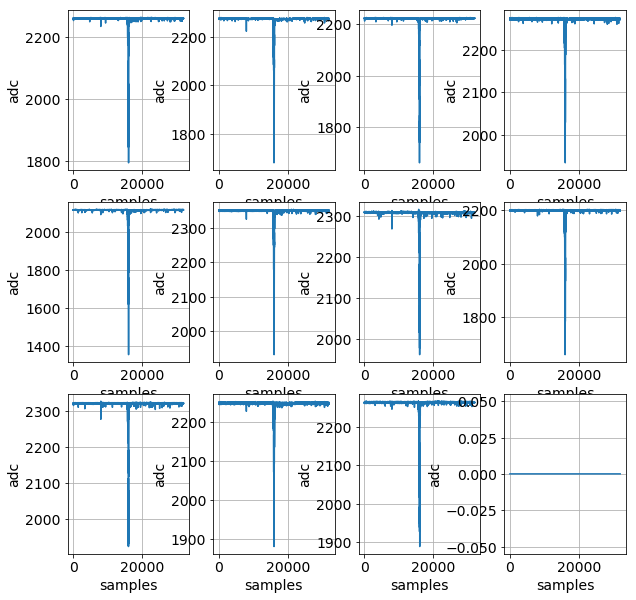

In [16]:
event = 0
mpl.plot_pmt_waveforms(pmtblr[event], zoom=False, window_size=1200, figsize=(10,10))

# Deconvolución offline

Es posible aplicar el algoritmo de deconvolución offline:

In [17]:
import invisible_cities.sierpe.blr as blr
from   invisible_cities.evm.ic_containers          import DeconvParams

In [18]:
deconv_params = DeconvParams(n_baseline = 28000,
                              thr_trigger = 5)


In [19]:
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)

En CWF están las waveforms deconvolucionadas siguendo la misma estructura (sensor, waveform):

In [20]:
CWF.shape

(11, 32000)

Plots de las waveforms deconvolucionadas:

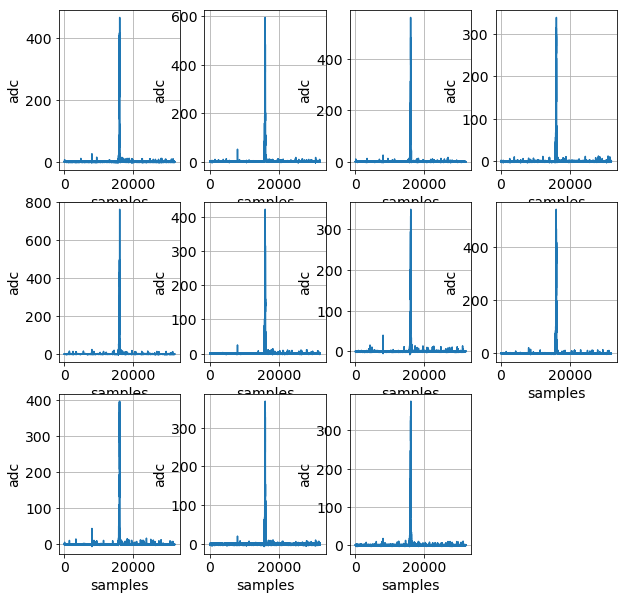

In [21]:
mpl.plot_pmt_waveforms(CWF, zoom=False, window_size=1200, figsize=(10,10))

# Escribir output

Si hace falta guardar algún resultado os dejo un código que crea un fichero hdf5, un dataset y puede ir añadiendo eventos

In [22]:
output_file = 'test.h5'
h5out = tb.open_file(output_file,'w')
table_name = 'pmtrwf'
compression = 'ZLIB4'
rwf_table = h5out.create_earray(h5out.root,
                                   table_name,
                                   atom    = tb.Int16Atom(),
                                   shape   = (0, sp.NPMT, sp.pmtwl),
                                   filters = tbl.filters(compression))

Añadir una waveform al array del fichero hdf5:

In [23]:
waveform = pmtrwf[0]

In [24]:
rwf_table.append(waveform.reshape(1, sp.NPMT, sp.pmtwl))

Cerrar fichero

In [25]:
h5out.close()